In [1]:
import yfinance as yf
import pandas as pd 
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize


# Section 1: Define Tickers and Time Range

### Define the list of tickers

In [2]:
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

### Set End Date to today

In [3]:
end_date = datetime.today()

### Set the start date to 5 years ago

In [4]:
start_date = end_date - timedelta(days = 5*365)
print(start_date)

2019-01-27 13:38:04.705112


# Section 2: Download Adjusted Close Prices

### Create an empty DateFrame to store the adjusted close prices

In [5]:
adj_close_df = pd.DataFrame()

### Download the close prices for each ticker

In [6]:
for ticker in tickers: 
    data = yf.download(ticker, start = start_date, end = end_date)
    adj_close_df[ticker] = data['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### Display the DataFrame

In [7]:
print(adj_close_df)

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2019-01-28  243.072311  69.876732  123.290001  157.828094  124.835274
2019-01-29  242.749802  70.017395  123.980003  156.337936  124.660225
2019-01-30  246.592651  70.087746  124.690002  160.314865  126.540039
2019-01-31  248.758408  70.412979  124.750000  162.714554  127.655037
2019-02-01  248.878174  70.217339  124.500000  162.027573  127.839378
...                ...        ...         ...         ...         ...
2024-01-19  482.429993  72.669998  187.929993  421.179993  239.539993
2024-01-22  483.450012  72.790001  187.220001  421.730011  240.580002
2024-01-23  484.859985  72.620003  187.949997  423.480011  241.020004
2024-01-24  485.390015  72.470001  186.399994  425.829987  240.979996
2024-01-25  488.029999  72.809998  187.139999  426.350006  242.320007

[1258 rows x 5 columns]


# Section 3: Calculate Lognormal Returns

### Calculate the Lognormal returns for each ticker

In [8]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))

### Drop any missing values

In [9]:
log_returns = log_returns.dropna()

# Section 4: Calculate the Covariance Matrix

Calculate the covariance matrix using annualized log returns

In [10]:
cov_matrix = log_returns.cov()*252
print(cov_matrix)

          SPY       BND       GLD       QQQ       VTI
SPY  0.044071  0.002732  0.003552  0.049616  0.045125
BND  0.002732  0.004612  0.003847  0.003378  0.002899
GLD  0.003552  0.003847  0.022368  0.004840  0.003716
QQQ  0.049616  0.003378  0.004840  0.064416  0.050752
VTI  0.045125  0.002899  0.003716  0.050752  0.046576


# Section 5: Define Portfolio Performance Metrics

### Calculate the portfolio standard deviation

This line of code calculates the portfolio variance, which is a measure of risk associated with a portfolio of assets. It represents the combined volatility of the assets in the portfolio, taking into account their individual volatilites and correlations with each other.

In [11]:
def standard_deviation (weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

### Calculate the expected return

*Key assumption: Expected returns are based on historical returns

In [13]:
def expected_return (weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

### Calculate the Sharpe Ratio

In [14]:
def sharpe_ratio (weight, log_returns, cov_matrix, risk_free_rate):
    return(expected_return (weights, log_returns) - risk_free_rate) / standard_deviation (weights, cov_matrix)

# Section 6: Portfolio Optimization

Set the risk-free rate

In [15]:
risk_free_rate = 0.02

In [48]:
from fredapi import Fred

#replace 'your_api_key' with your actual FRED API key
fred = Fred(api_key= '0f96c82000c4ec5ba751f77f4916354f')
ten_year_treasury_rate = fred.get_series_latest_release('GS10') /  100

#Set the risk free rate
risk_free_rate = ten_year_treasury_rate.iloc[-1]
print(risk_free_rate)

0.04019999999999999


### Define the function to minimize (negative Sharpe Ratio)

In the case of the scipy.optimize.minimize() function, there is no direct method to find the maximum value of a function

In [50]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

### Set the constraints and bounds

Constraints are conditions that must be met by the solution during the optimization process. In this case, the constraint is that the sum of all portfolio weights must be equal to 1. The contraints variable is a dictionary with two keys: 'type' and 'fun'. 'type' is set to 'eq', which means "equality constraint." and 'fun' is assigned the function check_sum, which checks the if the sum of the portfolio weight equals 1.

Bounds are the limits placed on the variables during the optimization process. In this case, the variables are the portfolio weights, and each weight should be between 0 and 1.

In [51]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.4) for _ in range(len(tickers))]

### Set the initial weights

In [52]:
initial_weights = np.array([1/len(tickers)]*len(tickers))
print(initial_weights)


[0.2 0.2 0.2 0.2 0.2]


### Optimize the weights to maximize Sharpe Ratio

'SLSQP' stands for Sequential Least Quadratic Programming, which is a numerical optimization technique suitable for solving nonlinear optimization technique suitable for solving nonlinear optimization problems with constraints

In [53]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)


### Get Optimal Weights

In [54]:
optimal_weights = optimized_results.x

# Section 7: Analyze the Optimal Portfolio

Display analytics of the optimal portfolio


In [56]:
optimal_weights = optimized_results.x

print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
SPY: 0.2000
BND: 0.0000
GLD: 0.0000
QQQ: 0.4000
VTI: 0.4000
Expected Annual Return: 0.0006
Expected Volatility: 0.2257
Sharpe Ratio: -0.1753


Display final portfolio in a plot

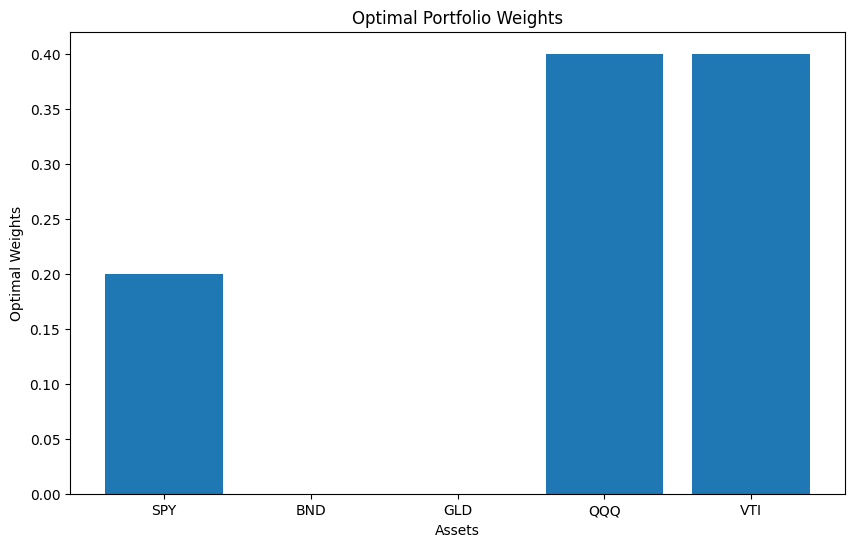

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()